z5208799 - Jonas Macken

First, let's install the libraries we will need for this project.

In [1]:
import gym # Used to create taxi environment
import numpy as np # Used for working with arrays
import matplotlib.pyplot as plt # Used for plotting results
from IPython.display import FileLink, display # Used to download trained Q tables
import warnings # We will use this to ignore some warnings that come up. These warnings don't impact our code running successfully, so ignoring them is just done for aesthetic purposes
warnings.filterwarnings("ignore", category=DeprecationWarning) # Ignore warnings generated related to the deprecated alias np.bool8. Our code is running fine, let's just ignore the warnings for aesthetic purposes

Now let's set up the taxi environment.

In [2]:
env = gym.make('Taxi-v3', render_mode='ansi').env # Initialise the Taxi-v3 environment
state = env.reset() # Reset the state
rendered_env = env.render() # Render an initial environment state
print(rendered_env)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Now that we've set up our environment, let's write some code that implements the Q-learning algorithm. Let's start by defining a function that implements Q-learning using an epsilon-greedy algorithm that takes a fixed epsilon value throughout the entire training process. We will set an upper bound of 2000 steps allowed per episode so our training does not take too long in the event that the agent is failing to reach the terminal state in early episodes. The value of 2000 has been chosen based on the example plots in the assignment description, where some early episodes in the Q-learning training are reaching close to 2000 steps.

In [3]:
def Q_learning_train(episodes, epsilon, gamma, alpha, max_steps = 2000):
    # Create our Q-table as a NumPy array, initialising all values to 0. 
    # The taxi environment has 500 total possible states (5 x 5 = 25 taxi locations, 4 possible passenger destinations, and 5 possible passenger locations (waiting at any of the stops or in the taxi). 
    # So, 25 x 4 x 5 = 500 total states. 
    # The number of actions we can take at any given state is 6, so our Q-table should have 500 rows and 6 columns.
    Q_table = np.zeros((500, 6))

    # Create arrays to store the number of steps taken and accumulated reward for each episode
    steps_per_episode = []
    accumulated_reward_per_episode = []
    
    # Begin the training process
    for i in range(episodes):

        # Initialise necessary values to begin episode
        state, info = env.reset() # Resets to a random environment state, returns a tuple with the state and additional info
        finished = False # Initialise to False as episode is not finished
        steps = 0
        accumulated_reward = 0

        # Continue the following loop until we have either dropped passenger off or reached max number of steps
        while not finished and steps < max_steps: 

            # Use epsilon-greedy approach to determine action for this step
            p = np.random.uniform(0, 1) # Select a random number between 0 and 1
            if p < epsilon: # Explore
                action = env.action_space.sample() # Picks a random action from the 6 options
            else: # Exploit
                options = Q_table[state] # Returns row of state (integer) we are in with all possible actions
                action = np.argmax(options) # Returns the index of max value in this array
        
            # Take action
            next_state, reward, finished, _, _ = env.step(action) # env.step() returns 5 values but we only want to make use of the first 3

            # Update Q value
            max_next_state = np.max(Q_table[next_state]) # Returns the highest Q value of all possible actions from the next state that our current action has moved us to
            updated_Q = (1 - alpha) * Q_table[state, action] + alpha * (reward + gamma * max_next_state) # Calculates updated Q value using Q-learning algorithm
            Q_table[state, action] = updated_Q # Updates Q value
            
            # Update state to be the new state we just moved to, update steps, and update accumulated reward
            state = next_state
            steps += 1
            accumulated_reward += reward
    
        # Add the total number of steps and total accumulated reward for this episode to their respective arrays
        steps_per_episode.append(steps)
        accumulated_reward_per_episode.append(accumulated_reward)
        
    return Q_table, steps_per_episode, accumulated_reward_per_episode

Now let's create a function that implements the SARSA algorithm, also using an epsilon-greedy approach. Note that a fixed epsilon value was first trialled, but this did not result in our agent reliably meeting target values. This is likely due to the fact that SARSA is an on-policy algorithm, meaning the updates to Q values are occasionally random if epsilon is non-zero. While a non-zero epsilon helps the agent to explore, random updates to Q don't improve it whatsoever, so it is hard to converge on an optimal solution if Q is always updated with some randomness. To combat this, I introduced a decay factor for epsilon. This decay factor means that in the initial stages, the agent gets the benefit of exploring new options, but in the later stages of training, epsilon reduces to zero, allowing the Q-table updates to be optimal and lead to convergence. An epsilon decay factor of 0.99 was chosen based on some research into commonly used values, and through some trial and error. Lower values tended to cause epsilon to decay too quickly, meaning not enough exploration was done.

Note that comments in code have been left out where code is similar to that in the above Q-learning function.

In [4]:
def SARSA_train(episodes, epsilon, gamma, alpha, max_steps = 2000, epsilon_decay_factor = 0.99, epsilon_min = 0):
    Q_table = np.zeros((500, 6))
    steps_per_episode = []
    accumulated_reward_per_episode = []
    
    for i in range(episodes):
        state, info = env.reset() 
        finished = False 
        steps = 0
        accumulated_reward = 0

        # We need to use epsilon-greedy to select the initial action before entering the while loop, as going forward we will select the next action in each iteration of the while loop
        p = np.random.uniform(0, 1) 
        if p < epsilon: 
            action = env.action_space.sample()
        else:
            options = Q_table[state]
            action = np.argmax(options)

        while not finished and steps < max_steps:   
            
            next_state, reward, finished, _, _ = env.step(action) # Need to get our next state so we can calculate the action from that state and use in our SARSA update rule

            # Use epsilon-greedy to select action from the next state
            p = np.random.uniform(0, 1) 
            if p < epsilon: 
                next_action = env.action_space.sample()
            else:
                next_options = Q_table[next_state]
                next_action = np.argmax(next_options)

            # Use SARSA algorithm to update Q-value for current state-action pair
            next_Q = Q_table[next_state, next_action] # Find the Q value of the action taken from our next state
            updated_Q = (1 - alpha) * Q_table[state, action] + alpha * (reward + gamma * next_Q) # Calculated updated Q from SARSA algorithm
            Q_table[state, action] = updated_Q # Update Q
            
            state = next_state # Move to next state
            action = next_action # Set our next action to be the one we already calculated in advance
            
            steps += 1
            accumulated_reward += reward

        # Decay epsilon after every training episode so exploration is reduced
        epsilon = max(epsilon_min, epsilon_decay_factor * epsilon)
    
        steps_per_episode.append(steps)
        accumulated_reward_per_episode.append(accumulated_reward)
    return Q_table, steps_per_episode, accumulated_reward_per_episode

Now let's define a function that evaluates our Q-learning and SARSA algorithms. This function will take in the trained Q-table that has been returned by our Q-learning or SARSA function, and by default will run 100 episodes, each with a maximum of 100 steps (i.e., the episode will terminate at 100 steps even if the passenger has not been dropped off). During the evaluation, the agent will use a greedy approach, always taking the action with the highest Q value at any given state. This will test whether our algorithms have learnt the most optimal action to take from any given state. The function will keep track of the number of steps and accumulated reward in each episode, and after all 100 testing episodes will calculate the average number of steps and average reward obtained per episode.

Again, we will leave out comments where code is similar to previous code.

In [5]:
def evaluate(Q_table, episodes = 100, max_steps = 100):

    # Initialise total number of steps and total reward across all episodes
    test_total_steps = 0
    test_total_accumulated_reward = 0

    # Begin the episodes with greedy approach
    for i in range(episodes):
        state, info = env.reset()
        episode_steps = 0
        episode_accumulated_reward = 0
        finished = False
        
        while not finished and episode_steps < max_steps:
            action = np.argmax(Q_table[state]) # Action is always the one with the highest Q value
            state, reward, finished, _, _ = env.step(action)       
            episode_steps += 1
            episode_accumulated_reward += reward

        # Add the number of steps from that episode and the reward to the total steps and reward
        test_total_steps += episode_steps
        test_total_accumulated_reward += episode_accumulated_reward
    
    # Calculate the average number of steps and reward per episode by diving the total by the number of episodes
    avg_steps = test_total_steps / episodes
    avg_accumulated_reward = test_total_accumulated_reward / episodes

    return avg_steps, avg_accumulated_reward

To select the best values for parameters epsilon, gamma, and alpha, we can use a grid search where we trial combinations of different values and manually select the ones that perform the best on average.

Our parameters all range between 0 and 1, so let's trial values between 0 and 1 (not inclusive) incrementing by 0.1. For gamma, however, lets start at 0.8 and go up to 1 in increments of 0.02. This is based on the idea that a high gamma favours future rewards over short-term ones, and doing this is crucial in our case.

The code below creates a dictionary for each parameter, and adds each result (step count and reward) to the key of each dictionary that corresponds to the value of that parameter that was used. For example, if we use epsilon = 0.1, alpha = 0.1, and gamma = 0.8, we will add the result of that combination to epsilon_dict[0.1], alpha_dict[0.1], and gamma_dict[0.8]. Then, after trialing all combinations, we will take the median result that was obtained for each value of each parameter. The value that performed the best (i.e., has the lowest median steps and highest median reward) will be adopted as the value for that parameter. For example, if cases where epsilon was 0.1 performed the best on average (best median), we will adopt epsilon = 0.1 to train our Q-table on.

We will do this approach for both Q-learning and SARSA.

Note that the code will be commented out so as to not be run during marking (as its very time consuming), but the resulting best values from executing this process are below. Note that the format of each key-value pair in a dictionary is "parameter value : (median number of steps in all tests that used this value, median reward in all tests that used this value)".

Q-LEARN PARAMS:

Epsilon dictionary:
{0.1: (17.74, 2.22), 0.2: (16.63, 3.42), 0.3: (16.17, 3.99), 0.4: (15.3, 5.18), 0.5: (14.95, 5.63), 0.6: (14.14, 6.64), 0.7: (13.56, 7.44), 0.8: (13.21, 7.79), 0.9: (13.22, 7.78)}

Alpha dictionary:
{0.1: (60.18, -51.35), 0.2: (27.68, -10.54), 0.3: (17.28, 2.67), 0.4: (15.08, 5.5), 0.5: (14.02, 6.72), 0.6: (13.45, 7.55), 0.7: (13.64, 7.23), 0.8: (13.31, 7.69), 0.9: (13.59, 7.41)}

Gamma dictionary:
{0.8: (15.47, 4.9), 0.82: (15.0, 5.58), 0.84: (15.23, 5.17), 0.86: (14.34, 6.3), 0.88: (14.96, 5.62), 0.9: (15.0, 5.58), 0.92: (15.12, 5.46), 0.94: (14.36, 6.28), 0.96: (14.13, 6.66), 0.98: (14.28, 6.15)}

By observation, the following parameters were chosen: Epsilon = 0.8, Alpha = 0.8, Gamma = 0.96.


SARSA PARAMS:

Epsilon dictionary:
{0.1: (23.04, -6.74), 0.2: (27.16, -10.7), 0.3: (30.58, -18.84), 0.4: (32.72, -16.82), 0.5: (38.14, -23.93), 0.6: (37.72, -22.49), 0.7: (45.32, -31.98), 0.8: (41.18, -26.7), 0.9: (49.67, -37.39)}

Alpha dictionary:
{0.1: (64.33, -67.6), 0.2: (31.64, -16.02), 0.3: (23.02, -5.72), 0.4: (21.1, -4.26), 0.5: (23.6, -7.86), 0.6: (36.0, -20.56), 0.7: (38.63, -23.71), 0.8: (55.08, -44.16), 0.9: (64.14, -55.32)}

Gamma dictionary:
{0.8: (64.66, -56.72), 0.82: (55.84, -46.58), 0.84: (57.89, -47.6), 0.86: (48.19, -35.38), 0.88: (40.5, -26.01), 0.9: (35.13, -20.49), 0.92: (26.06, -9.35), 0.94: (22.47, -3.85), 0.96: (18.74, 0.7), 0.98: (18.08, 1.42)}

By observation, the following parameters were chosen: Epsilon = 0.1, Alpha = 0.4, Gamma = 0.98.




Below is the Q-learning parameter grid search.

In [6]:
# # Create array of a range of values to trial for our parameters
# epsilon_values = np.arange(0.1, 1.0, 0.1)
# alpha_values = np.arange(0.1, 1.0, 0.1)
# gamma_values = np.arange(0.8, 1.0, 0.02)

# # Create dictionaries for each of the parameters
# epsilon_dict = {}
# alpha_dict = {}
# gamma_dict = {}

# #  Create a key in the dictionary for each parameter value, and set the key's value to an empty list that will be added to
# for value in epsilon_values:
#     epsilon_dict[round(value,2)] = []

# for value in alpha_values:
#     alpha_dict[round(value,2)] = []

# for value in gamma_values:
#     gamma_dict[round(value,2)] = []

# iter = 0 # Counter to keep track of how fast this code is running

# # Run a triple for loop so that each combination of values for all 3 parameters is considered
# for epsilon in epsilon_values:
#     for alpha in alpha_values:
#         for gamma in gamma_values:
#             iter += 1
#             print(iter)
#             Q_table, _, _ = Q_learning_train(1000, epsilon, gamma, alpha, 200) # Train on this combination, limit to 1000 training episodes and 200 episode steps to reduce training time
#             avg_steps, avg_accumulated_reward = evaluate(Q_table)
#             epsilon_dict[round(epsilon,2)].append((avg_steps, avg_accumulated_reward)) #Add the results to the relevant key list in the epsilon dictionary
#             alpha_dict[round(alpha,2)].append((avg_steps, avg_accumulated_reward))
#             gamma_dict[round(gamma,2)].append((avg_steps, avg_accumulated_reward))

# # For each key in each dictionary, replace the list with a tuple of the median average steps and the median accumulated reward of all combinations that used that parameter value
# for key in epsilon_dict:
#     steps_rewards_list = epsilon_dict[key]
#     avg_steps = np.median([x[0] for x in steps_rewards_list])
#     avg_rewards = np.median([x[1] for x in steps_rewards_list])
#     epsilon_dict[key] = (round(avg_steps,2), round(avg_rewards,2))

# for key in alpha_dict:
#     steps_rewards_list = alpha_dict[key]
#     avg_steps = np.median([x[0] for x in steps_rewards_list])
#     avg_rewards = np.median([x[1] for x in steps_rewards_list])
#     alpha_dict[key] = (round(avg_steps,2), round(avg_rewards,2))

# for key in gamma_dict:
#     steps_rewards_list = gamma_dict[key]
#     avg_steps = np.median([x[0] for x in steps_rewards_list])
#     avg_rewards = np.median([x[1] for x in steps_rewards_list])
#     gamma_dict[key] = (round(avg_steps,2), round(avg_rewards,2))

# print(epsilon_dict)
# print(alpha_dict)
# print(gamma_dict)

Below is the SARSA parameter grid search.

In [7]:
# epsilon_values = np.arange(0.1, 1.0, 0.1)
# alpha_values = np.arange(0.1, 1.0, 0.1)
# gamma_values = np.arange(0.8, 1.0, 0.02)

# epsilon_dict = {}
# alpha_dict = {}
# gamma_dict = {}

# for value in epsilon_values:
#     epsilon_dict[round(value,2)] = []

# for value in alpha_values:
#     alpha_dict[round(value,2)] = []

# for value in gamma_values:
#     gamma_dict[round(value,2)] = []

# iter = 0

# for epsilon in epsilon_values:
#     for alpha in alpha_values:
#         for gamma in gamma_values:
#             iter += 1
#             print(iter)
#             Q_table, _, _ = SARSA_train(1000, epsilon, gamma, alpha, 200)
#             avg_steps, avg_accumulated_reward = evaluate(Q_table)
#             epsilon_dict[round(epsilon,2)].append((avg_steps, avg_accumulated_reward))
#             alpha_dict[round(alpha,2)].append((avg_steps, avg_accumulated_reward))
#             gamma_dict[round(gamma,2)].append((avg_steps, avg_accumulated_reward))



# for key in epsilon_dict:
#     steps_rewards_list = epsilon_dict[key]
#     avg_steps = np.median([x[0] for x in steps_rewards_list])
#     avg_rewards = np.median([x[1] for x in steps_rewards_list])
#     epsilon_dict[key] = (round(avg_steps,2), round(avg_rewards,2))

# for key in alpha_dict:
#     steps_rewards_list = alpha_dict[key]
#     avg_steps = np.median([x[0] for x in steps_rewards_list])
#     avg_rewards = np.median([x[1] for x in steps_rewards_list])
#     alpha_dict[key] = (round(avg_steps,2), round(avg_rewards,2))

# for key in gamma_dict:
#     steps_rewards_list = gamma_dict[key]
#     avg_steps = np.median([x[0] for x in steps_rewards_list])
#     avg_rewards = np.median([x[1] for x in steps_rewards_list])
#     gamma_dict[key] = (round(avg_steps,2), round(avg_rewards,2))

# print(epsilon_dict)
# print(alpha_dict)
# print(gamma_dict)


Now that we have identified which values for each parameter perform best on average for both Q-learning and SARSA, let's try adopting these values and observing results.

Again, since this code doesn't need to be run during the discussion, we will comment it out and instead will paste the results from running it below.

Results from running the below code:

Q-learning results: Average Steps  = 13.66, Average Reward = 7.34


SARSA results: Average Steps  = 21.48, Average Reward = -29.37

In [8]:
# Q_table, _, _ = Q_learning_train(1000, 0.8, 0.96, 0.8)
# Q_avg_steps, Q_avg_accumulated_reward = evaluate(Q_table)
# print(f'Q-learning results: Average Steps  = {Q_avg_steps}, Average Reward = {Q_avg_accumulated_reward}')

# Q_table, _, _ = SARSA_train(1000, 0.1, 0.98, 0.4)
# Q_avg_steps, Q_avg_accumulated_reward = evaluate(Q_table)
# print(f'SARSA results: Average Steps  = {Q_avg_steps}, Average Reward = {Q_avg_accumulated_reward}')

Results for Q-learning look good, but SARSA results are not as good as we'd like. For Q-learning, lets leave all the parameters as is. For SARSA, let's try increasing the number of episodes in the training process (while maintaining the same parameter values) to see if results improve. Let's compare results for training with 1000, 2000, 5000, and 10000 episodes. Again, we will comment the code out and paste results from running it below.

Results from running the below code:

SARSA results with 1000 training episodes: Average Steps  = 15.93, Average Reward = 4.44



SARSA results with 2000 training episodes: Average Steps  = 13.06, Average Reward = 7.94



SARSA results with 5000 training episodes: Average Steps  = 13.47, Average Reward = 7.53



SARSA results with 10000 training episodes: Average Steps  = 14.14, Average Reward = 6.86

In [9]:
# episode_values = [1000, 2000, 5000, 10000]

# for value in episode_values:
#     Q_table, _, _ = SARSA_train(value, 0.1, 0.98, 0.4)
#     Q_avg_steps, Q_avg_accumulated_reward = evaluate(Q_table)
#     print(f'SARSA results with {value} training episodes: Average Steps  = {Q_avg_steps}, Average Reward = {Q_avg_accumulated_reward}')

Results with 2000 or more training episodes look acceptable. Since there is some variance in results based on randomness in initialising environment states in training, let's run 50 iterations of training and testing with each of the values in episode_values and count how many times out of the 50 iterations that the trained agent meets the requirements. We will adopt the minimum number of training episodes such that the agent meets the requirements in all 50 trials. Again, we will comment the code out and paste results from running it below. Here we will also double check that the adopted number of training episodes for Q-learning is sufficient (i.e., the agent meets requirements in all 50 iterations of training it on 1000 episodes with the selected parameters).

Results from running the below code:

Q learning:

50 / 50 passed with 1000 training episodes

SARSA:

9 / 50 passed with 1000 training episodes

47 / 50 passed with 2000 training episodes

50 / 50 passed with 5000 training episodes

50 / 50 passed with 10000 training episodes

In [10]:
# print('Q learning:')

# Q_count = 0
# for i in range(50):
#     Qlearn_Q_table, steps_per_episode, _ = Q_learning_train(1000, 0.8, 0.96, 0.8)
#     Q_avg_steps, Q_avg_accumulated_reward = evaluate(Qlearn_Q_table)
#     if Q_avg_steps >= 14 or Q_avg_accumulated_reward <=7: # If it doesn't meet requirements, don't add to the count
#         continue
#     else: # Results are in acceptable range, add 1 to the count
#         Q_count += 1
# print(f'{Q_count} / 50 passed with 1000 training episodes')

# print('\n')

# print('SARSA:')

# episode_values = [1000, 2000, 5000, 10000]

# for value in episode_values:
#     SARSA_count = 0
#     for i in range(50):
#         SARSA_Q_table, _, _ = SARSA_train(value, 0.1, 0.98, 0.4)
#         Q_avg_steps, Q_avg_accumulated_reward = evaluate(SARSA_Q_table)
#         if Q_avg_steps >= 15 or Q_avg_accumulated_reward <= 5:
#             continue
#         else:
#             SARSA_count += 1
#     print(f'{SARSA_count} / 50 passed with {value} training episodes')

From the above trials, we see that the training Q-learning with 1000 episodes works consistently, while for SARSA the lowest number of episodes in our range of trials for the agent to consistently reach targets is 5000. So, let's adopt 1000 training episodes for Q-learning and 5000 training episodes for SARSA.

Let's now train our agent on these finalised parameters and plot the improvements throughout training.

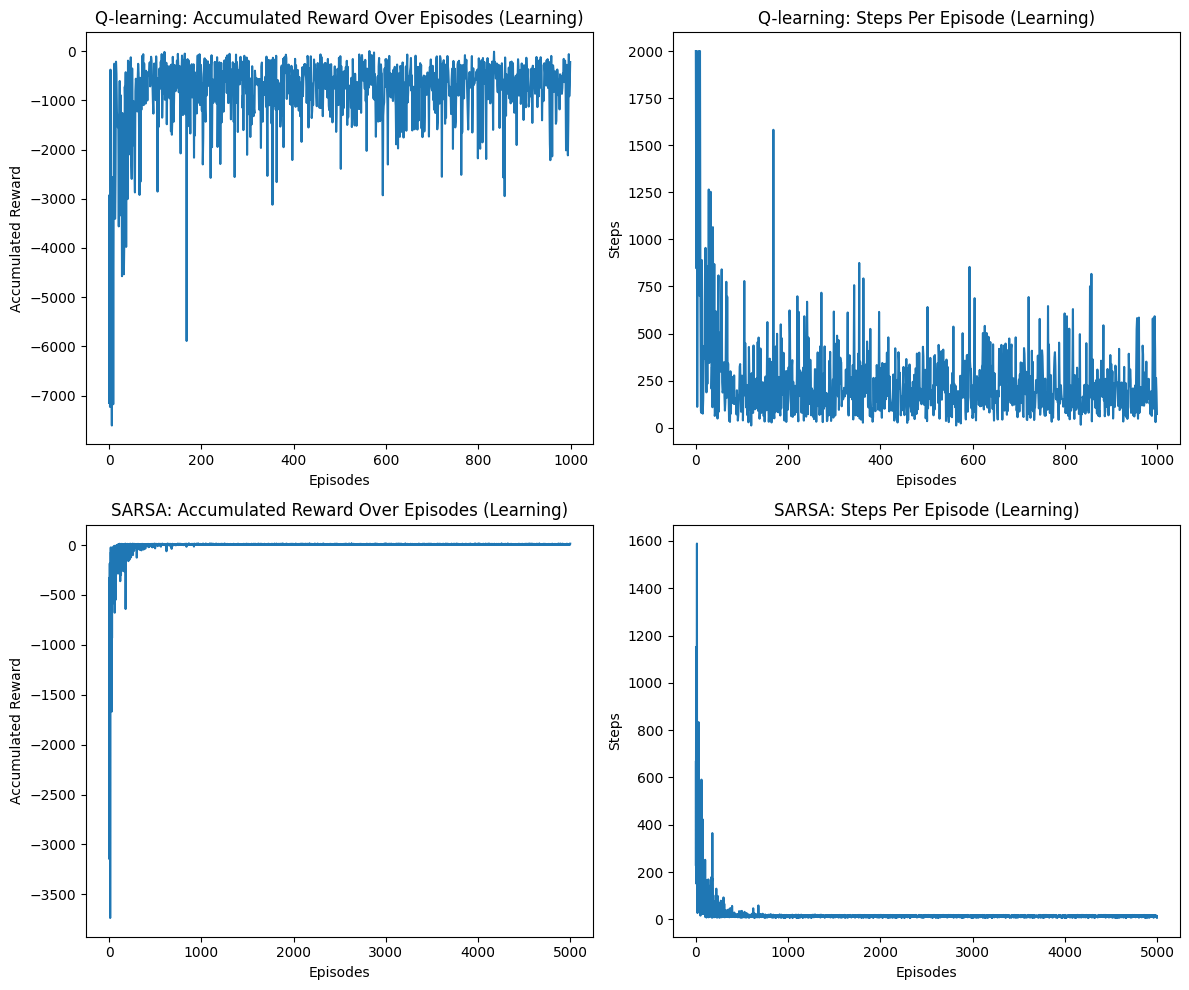

In [11]:
Qlearn_Q_table, Qlearn_train_steps, Qlearn_train_rewards = Q_learning_train(1000, 0.9, 0.86, 0.9)
SARSA_Q_table, SARSA_train_steps, SARSA_train_rewards = SARSA_train(5000, 0.1, 0.98, 0.4)

# Plotting the results

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(Qlearn_train_rewards)
plt.title('Q-learning: Accumulated Reward Over Episodes (Learning)')
plt.xlabel('Episodes')
plt.ylabel('Accumulated Reward')

plt.subplot(2, 2, 2)
plt.plot(Qlearn_train_steps)
plt.title('Q-learning: Steps Per Episode (Learning)')
plt.xlabel('Episodes')
plt.ylabel('Steps')

plt.subplot(2, 2, 3)
plt.plot(SARSA_train_rewards)
plt.title('SARSA: Accumulated Reward Over Episodes (Learning)')
plt.xlabel('Episodes')
plt.ylabel('Accumulated Reward')

plt.subplot(2, 2, 4)
plt.plot(SARSA_train_steps)
plt.title('SARSA: Steps Per Episode (Learning)')
plt.xlabel('Episodes')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

Now let's save our trained Q-tables for both Q-learning and SARSA. These will then be called up during the tutorial discussion for evaluation.

This code has been commented out so that in the tutorial new files aren't generated, but the Q-table files submitted with the assignment were generated using this method.

In [12]:
# np.save('Qlearn_Q_table.npy', Qlearn_Q_table) # Save Qlearn table
# np.save('SARSA_Q_table.npy', SARSA_Q_table) # Save SARSA table

# # Create links to download the files
# display(FileLink('Qlearn_Q_table.npy'))
# display(FileLink('SARSA_Q_table.npy'))

The remainder of this notebook is for use in the tutorial discussion.

We will download the zip file from Moodle and put the ipynb file and the 2 Q-table files in the same folder so that when showing our tutor we can run the following code and it will successfully load in and work with the Q-tables we submitted.

Now, let's load in both of our Q-tables.

In [13]:
testing_Qlearn_Q_table = np.load('Qlearn_Q_table.npy')
testing_SARSA_Q_table = np.load('SARSA_Q_table.npy')

Now, let's evaluate their performance over 100 episodes using our evaluation function and display the results to ensure they are meeting the targets.

In [14]:
warnings.filterwarnings("ignore", category=DeprecationWarning) # Ignore warnings generated related to the deprecated alias np.bool8. Our code is running fine, let's just ignore the warnings for aesthetic purposes

Qlearn_Q_avg_steps, Qlearn_Q_avg_accumulated_reward = evaluate(testing_Qlearn_Q_table)
print(f'Q-learning: Average Steps = {Qlearn_Q_avg_steps}, Average Rewards = {Qlearn_Q_avg_accumulated_reward}')

SARSA_Q_avg_steps, SARSA_Q_avg_accumulated_reward = evaluate(testing_SARSA_Q_table)
print(f'SARSA: Average Steps = {SARSA_Q_avg_steps}, Average Rewards = {SARSA_Q_avg_accumulated_reward}')

Q-learning: Average Steps = 12.82, Average Rewards = 8.18
SARSA: Average Steps = 13.7, Average Rewards = 7.3


Now let's display one full episode each for the learned Q-tables from the Q-learning and SARSA algorithm to demonstrate that our agent is indeed taking the optimal route in a given scenario.

Let's first observe an episode based on the Q-learning Q-table.

In [15]:
state, info = env.reset()
episode_steps = 0
episode_accumulated_reward = 0
finished = False

while not finished:
    action = np.argmax(testing_Qlearn_Q_table[state]) # We use a greedy approach during testing, so action is always the one with the highest Q value
    state, reward, finished, _, _ = env.step(action)       
    episode_steps += 1
    episode_accumulated_reward += reward
    print(env.render())
    print(f"Step: {episode_steps}")
    print(f"State: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {episode_accumulated_reward}")
    print('\n')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1
State: 368, Action: 1, Reward: -1, Total Accumulated Reward: -1


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 2
State: 268, Action: 1, Reward: -1, Total Accumulated Reward: -2


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3
State: 248, Action: 3, Reward: -1, Total Accumulated Reward: -3


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 4
State: 228, Action: 3, Reward: -1, Total Accumulated Reward: -4


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 5
State: 208, Action: 3, Reward: -1, Total Accumulated Reward: -5


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 6
State: 308, Action: 0, Reward: -1, Total Accumulated Re

Now let's observe an episode based on the SARSA Q-table.

In [16]:
state, info = env.reset()
episode_steps = 0
episode_accumulated_reward = 0
finished = False

while not finished:
    action = np.argmax(testing_SARSA_Q_table[state])
    state, reward, finished, _, _ = env.step(action)       
    episode_steps += 1
    episode_accumulated_reward += reward
    print(env.render())
    print(f"Step: {episode_steps}")
    print(f"State: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {episode_accumulated_reward}")
    print('\n')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1
State: 353, Action: 1, Reward: -1, Total Accumulated Reward: -1


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 2
State: 253, Action: 1, Reward: -1, Total Accumulated Reward: -2


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 3
State: 153, Action: 1, Reward: -1, Total Accumulated Reward: -3


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 4
State: 173, Action: 2, Reward: -1, Total Accumulated Reward: -4


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 5
State: 193, Action: 2, Reward: -1, Total Accumulated Reward: -5


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 6
State: 293, Action: 0, Reward: -1, Total Accumulated R